# Training & Evaluation 
* In this notebook we are going to train a simple object detection CNN from scratch. 
* We'll reuse similar CNN that we used for image classification. 
* We'll use the optimized data generation script to generate the training data. 

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
import matplotlib.pyplot as plt
import matplotlib.patches as patches



## validate tensorflow 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Constants

In [2]:
data_dir = Path("..","data")
models_dir = Path("..","models")

In [3]:
import os
import sys
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import graph_compatible_data_generator

## logic to auto reload scripts without restarting the kernel
%load_ext autoreload
%autoreload 2

I0000 00:00:1761688833.581437   46593 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6053 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:2e:00.0, compute capability: 7.5


## Initialize Pipeline

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
# X_tensor = tf.reshape(X_tensor, shape=(-1, 28, 28, 1))
y_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)


raw_dataset = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))

# create a generator for 2 digits
data_gen_2_digits = graph_compatible_data_generator.create_data_generator(2)

processed_dataset_2 = raw_dataset.map(
    data_gen_2_digits).batch(32).prefetch(tf.data.AUTOTUNE)

--- Loading and caching MNIST data... ---


### Validating Pipeline

batched_canvases shape: (32, 100, 100)
predictions shape  tf.Tensor([32  5 15], shape=(3,), dtype=int32)
Canvas shape: (100, 100)
Single Prediction shape: (5, 15)


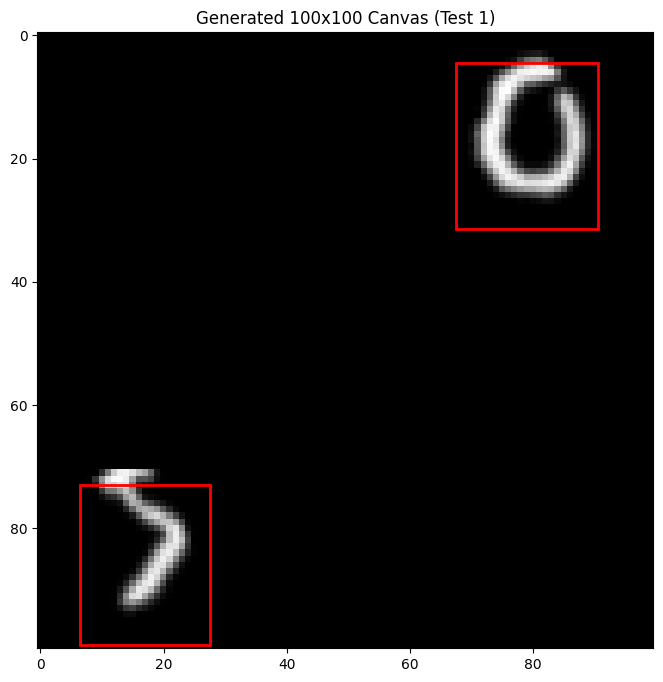

In [11]:
def visualize_generated_data(batch):
    batched_canvases,predictions = batch
    print(f"batched_canvases shape: {batched_canvases.shape}")
    print(f"predictions shape ", tf.shape(predictions))
    # Get the very first canvas from the batch (shape 100x100)
    # We use .numpy() to convert it from a EagerTensor to a NumPy array for plotting
    canvas_to_show = batched_canvases[0].numpy()
    prediction = predictions[0]

    print(f"Canvas shape: {canvas_to_show.shape}")
    print(f"Single Prediction shape: {prediction.shape}")
    
    
    # # Plot it
    # # --- Create a figure and axis ---
    fig, ax = plt.subplots(1, figsize=(8, 8))
    
    # get the 2 predictions
    for i in range(2):
        bbox = (prediction[i]).numpy() * 100
        
        # flag, x_center, y_center, width, height,
        flag = bbox[0]
        x_center = bbox[1]
        y_center = bbox[2]
        width = bbox[3]
        height = bbox[4]
        
        x_min = x_center - (width / 2)
        y_min = y_center - (width / 2)        
        # print("flag, x_center, y_center, width, height",flag, x_min, y_min, width, height,)
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        
        ax.add_patch(rect)
    # Display the image
    ax.imshow(canvas_to_show, cmap='gray')
    
    
    plt.title("Generated 100x100 Canvas (Test 1)")
    plt.show()


# Get one batch
# Your dataset is batched, so .take(1) gets one full batch
for batch in processed_dataset_2.take(1):
    visualize_generated_data(batch=batch)